# Customer Churn Prediction

### Step 1: Inspect and clean dataset, convert data types

In [30]:
import pandas as pd

df=pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##### Shape of our Dataset

In [31]:
print('Dataset Shape:', df.shape)

Dataset Shape: (7043, 21)


> The Dataset Shape inform us about the size of the raws and columns in the dataset, delivering:
> * 7043 customers — a reasonable size for making our ML modeling (train/test split will give ~5,282 training, 1,761 test if we use 75/25 split).
>
> * 21 columns — in which includes target (Churn) and customerID, our unique identifier.
>
> __Implication:__ Enough data for logistic regression and tree-based models. CustomerID will not be used as a feature, only as an identifier if needed for joining later.

##### Check any missing values

In [32]:
print('Missing Values:', df.isnull().sum())

Missing Values: customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


> All the columns display (0) zero missing values, letting us know that the dataset contains no NaN in numeric or categorical columns.
>
> However, TotalCharges is object type, so some "blanks" may be stored as empty strings and not recognized as NaN. So we first need to convert TotalCharges to numeric and handle conversion errors (errors='coerce') to properly detect missing values.

##### Check Data Types

In [33]:
print('Data Types:', df.dtypes)

Data Types: customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


> Many of our data types are stored as __object__ type columns: mostly categorical (gender, Partner, Dependents, service features, PaymentMethod, Churn).
> 
> As __int64__ we have: SeniorCitizen, tenure — already numeric.
>
> As __float64__: MonthlyCharges.
>
> __Object__ TotalCharges: should be numeric. Likely caused by some rows with blank strings.
>
> __Implication:__
>
> * We need to convert TotalCharges to float.
>
> * All categorical columns must be encoded to numeric (either 0/1 for binary, one-hot or ordinal for multi-class).
>
> * Ensure the target Churn is 0/1 for ML modeling.

##### Check Target Distribution

In [34]:
df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

> About __26.5%__ customers are __churners__ and about __73.5% non-churners__ → we have class imbalance, but not extreme.
>
> Logistic regression / XGBoost can handle this, but for the evaluation process metrics like precision/recall will be important, not just accuracy.

> __Implication:__
>
> * We may want stratified train/test split to preserve target proportion.
>
> * We may consider precision-recall curves or threshold tuning later due to imbalance.

#### Conclusions

1. The dataset is largely clean, with no explicit missing values.

2. TotalCharges needs type conversion to numeric.

3. Many categorical features need encoding (Yes/No → 1/0, multi-class → one-hot).

4. Target distribution shows moderate imbalance — track metrics beyond accuracy.

5. customerID is a non-feature.

#### Actions

Before moving to the next steps like data cleaning, preprocessing and modeling, we should:

* Check TotalCharges conversion: This will tell us if any rows had blank TotalCharges. We can drop or impute them.

* Inspect unique values in categorical features (especially those with No internet service / No phone service) — these will need consistent mapping to 0/1.

* Decide feature types — separate numerical vs categorical. This will guide scaling, encoding, and model selection.

In [35]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].isnull().sum()

np.int64(11)

> Now we have 11 missing values in the TotalCharges column.

In [36]:
for col in df.select_dtypes(include='object').columns:
    print(f"{col} unique values: {df[col].unique()}")

customerID unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender unique values: ['Female' 'Male']
Partner unique values: ['Yes' 'No']
Dependents unique values: ['No' 'Yes']
PhoneService unique values: ['No' 'Yes']
MultipleLines unique values: ['No phone service' 'No' 'Yes']
InternetService unique values: ['DSL' 'Fiber optic' 'No']
OnlineSecurity unique values: ['No' 'Yes' 'No internet service']
OnlineBackup unique values: ['Yes' 'No' 'No internet service']
DeviceProtection unique values: ['No' 'Yes' 'No internet service']
TechSupport unique values: ['No' 'Yes' 'No internet service']
StreamingTV unique values: ['No' 'Yes' 'No internet service']
StreamingMovies unique values: ['No' 'Yes' 'No internet service']
Contract unique values: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling unique values: ['Yes' 'No']
PaymentMethod unique values: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

> From the inspection of the unique values we need to do some actions.

<br />

### Observations from Unique Values

1. `customerID`

- Unique identifier → we will drop it for modeling.

<br />

2. __Binary categorical variables (Yes/No)__

`gender` (Female/Male), `Partner`, `Dependents`, `PhoneService`, `PaperlessBilling`, `Churn`

- These can be encoded as 0/1 (e.g., Yes=1, No=0; Female=0, Male=1).

<br />

3. __Categorical variables with “No internet service” or “No phone service”__

`MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`

- The values are either Yes, No, or No internet service / No phone service

- These can be encoded carefully:

        - Map Yes → 1

        - Map No → 0

        - Map No internet service / No phone service → 0
(This treats “no service” as equivalent to not having the feature, which makes sense for modeling.)


<br />

4. __Multi-class categorical variables__

- `InternetService`: DSL, Fiber optic, No → one-hot encode

- `Contract`: Month-to-month, One year, Two year → one-hot encode or ordinal encoding (shorter contracts may have higher churn)

- `PaymentMethod`: multiple options → one-hot encode


<br />

5. __Numeric variables__

- `SeniorCitizen`: already int64 → keep as numeric

- `tenure`: int64 → numeric

- `MonthlyCharges`: float64 → numeric

- `TotalCharges`: currently object → convert to numeric (already noted)

> __Actions__
>
> Dropping Missing values from `TotalCharges`

In [37]:
df= df.dropna(subset='TotalCharges')
print('New Dataset after dropping missing values:', df.shape)

New Dataset after dropping missing values: (7032, 21)


> Converting Data Types Status

In [38]:
df['TotalCharges']=df['TotalCharges'].astype(float)

> Binary columns → 0/1
>
> Columns: `gender, Partner, Dependents, PhoneService, PaperlessBilling, Churn`

In [39]:
binary_cols = ['gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn']
service_cols = ['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection',
                'TechSupport','StreamingTV','StreamingMovies']

for col in binary_cols + service_cols:
    df[col] = df[col].astype(str).str.strip()

In [40]:
binary_map = {'Yes':1, 'No':0, 'Female':0, 'Male':1}

for col in binary_cols:
    df[col] = df[col].map(binary_map)

In [41]:
service_map = {'Yes':1, 'No':0, 'No internet service':0, 'No phone service':0}

for col in service_cols:
    df[col] = df[col].map(service_map)

In [42]:
print("NaNs after mapping:", df[binary_cols + service_cols].isnull().sum())

NaNs after mapping: gender              0
Partner             0
Dependents          0
PhoneService        0
PaperlessBilling    0
Churn               0
MultipleLines       0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


> Multi-class categorical columns

In [43]:
multi_cols = ['InternetService','Contract','PaymentMethod']

for col in multi_cols:
    print(f"{col} unique values: {df[col].unique()}")

InternetService unique values: ['DSL' 'Fiber optic' 'No']
Contract unique values: ['Month-to-month' 'One year' 'Two year']
PaymentMethod unique values: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   int64  
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   int64  
 4   Dependents        7032 non-null   int64  
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   int64  
 7   MultipleLines     7032 non-null   int64  
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   int64  
 10  OnlineBackup      7032 non-null   int64  
 11  DeviceProtection  7032 non-null   int64  
 12  TechSupport       7032 non-null   int64  
 13  StreamingTV       7032 non-null   int64  
 14  StreamingMovies   7032 non-null   int64  
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   int64  
 17  

> We now have clean data, types are correct, no missing values, and target is ready for modeling.

In [45]:
df = df.drop("customerID", axis=1)

### Feature Engineering & Preprocessing

__Objective:__ Prepare the dataset for machine learning by transforming categorical variables, scaling numeric features, creating a clean feature matrix, and splitting into training and test sets.

##### One-Hot Encoding of Multi-Class Categorical Features

> `InternetService, Contract, PaymentMethod`


> These features are categorical with more than two categories. The Logistic regression model that we want to build requires numeric input, so we convert each category into a binary column (0/1) using one-hot encoding.
> 
> `drop_first=True` avoids multicollinearity 

In [46]:
multi_cols=['InternetService', 'Contract', 'PaymentMethod']

df = pd.get_dummies(df, columns = multi_cols, drop_first=True)
print('New columns after one-hot encoding: ', df.columns.tolist())

New columns after one-hot encoding:  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


##### Feature Separation: X (features) and y (target)

> Churn (0 = No, 1 = Yes)

In [47]:
# Target (y)
y = df['Churn']

# Feature (x)
X = df.drop(columns=['Churn'])

print("Feature Shape:", X.shape)
print("Target Shape:", y.shape)

Feature Shape: (7032, 23)
Target Shape: (7032,)


##### Scaling Numeric Features (for Logistic Regression)

> `SeniorCitizen, tenure, MonthlyCharges, TotalCharges`
> 
> Logistic regression is sensitive to feature scale.
> Scaling ensures coefficients are interpretable and gradient descent converges efficiently
>
> For tree-based models (e.g., XGBoost), scaling is not required.

In [48]:
from sklearn.preprocessing import StandardScaler

num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print(X[num_cols].head())

   SeniorCitizen    tenure  MonthlyCharges  TotalCharges
0      -0.440327 -1.280248       -1.161694     -0.994194
1      -0.440327  0.064303       -0.260878     -0.173740
2      -0.440327 -1.239504       -0.363923     -0.959649
3      -0.440327  0.512486       -0.747850     -0.195248
4      -0.440327 -1.239504        0.196178     -0.940457


##### Train-Test Split

The startegy that we will use here is:

> 75% training, 25% testing

> Stratified split to maintain churn proportion in both sets

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, stratify = y)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (5274, 23)
Test set shape: (1758, 23)


##### Interaction & Derived Features

__Average Monthly Spend__

In [50]:
# Avoid division by zero
df['AvgMonthlySpend'] = df['TotalCharges'] / (df['tenure'].replace(0, 1))

__High-Risk Customer Flags__

In [51]:
df['HighMonthlyCharges'] = (df['MonthlyCharges'] > df['MonthlyCharges'].median()).astype(int)

df['ShortTenure'] = (df['tenure'] < 6).astype(int)   

__Correlation & Multicollinearity Check__

Linear models like logistic regression suffer when features are highly correlated (multicollinearity).
Tree models (e.g., XGBoost) don’t suffer, but it's still good practice to inspect.

We keep all features because tree models and logistic regression can both handle them after scaling, but in a more strict environment we might drop one of the correlated columns.

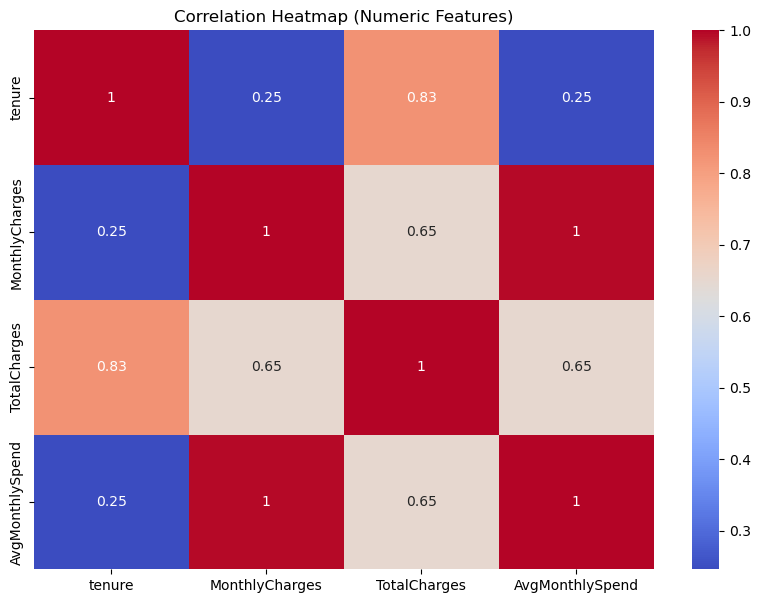

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.heatmap(df[['tenure','MonthlyCharges','TotalCharges','AvgMonthlySpend']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

__Outlier Detection (Numeric Features)__

Numeric anomalies can destabilize logistic regression and distort scaling.

Check with simple IQR method:

In [53]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend']

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")

tenure: 0 outliers
MonthlyCharges: 0 outliers
TotalCharges: 0 outliers
AvgMonthlySpend: 0 outliers


### Model Building & Evaluation

#### Logistic Regression (Baseline Model)
<br />

##### Prepare Features (X) and Target (y)

We first split the dataset into:

* X = all features

* y = Churn (0 = No, 1 = Yes)

In [54]:
X = df.drop("Churn", axis = 1)
y = df["Churn"]

__Train/Test Split (80/20)__

We split data while maintaining class balance using stratify=y.

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)


__Feature Scaling__

Logistic Regression requires scaled numeric features for:

* stable coefficient estimation

* faster convergence

* avoiding numerical instability

We use StandardScaler, applied only to training data

In [56]:
from sklearn.preprocessing import StandardScaler

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend']

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

__Train Logistic Regression__

Regularization is important, so we use `liblinear` solver.

In [57]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter = 100, solver = 'liblinear')
log_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


__Predictions__

In [58]:
y_pred = log_model.predict(X_test)
y_prod = log_model.predict_proba(X_test)[:,1]

__Model Evaluation__

Accuracy | Precision | Recall | F1

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.7953091684434968
Precision: 0.6352201257861635
Recall: 0.5401069518716578
F1 Score: 0.5838150289017341


__Confusion Matrix__

This is essential for churn analysis, because false negatives (predicting non-churn when customer actually churns) are costly.

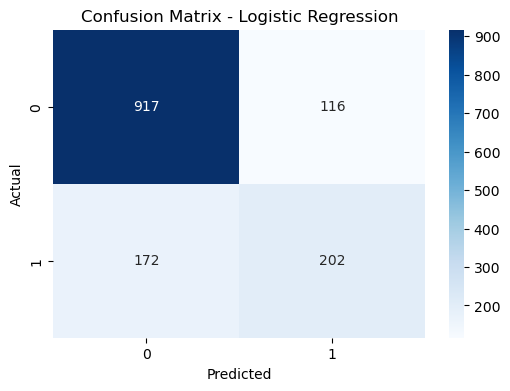

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap ='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

> * False Negatives (172) → churners predicted as non-churn → primary risk.
>
> * False Positives (116) → predicted churn but actually stayed → less costly, may trigger marketing unnecessarily.

__Classification Report__

In [63]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.54      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



>__Accuracy__:
> * 80% of all predictions are correct.
> * Accuracy alone can be misleading because the dataset is imbalanced (~27% churn rate).
>
>__Precision and Recall__:
> * Class 0 (No churn)
>
>    - High precision & recall → most non-churning customers are correctly identified.

> * Class 1 (Churn)
> 
>    - Precision 0.64 → of all customers predicted to churn, 64% actually churned
>    - Recall 0.54 → model only captures 54% of actual churners
>    - F1-score 0.58 → harmonic mean of precision & recall; moderate performance

Missing churners (false negatives) is costly in business — customers leave without retention efforts.

### Summary

* Logistic Regression gives a good baseline (~80% accuracy).

* Weakness: detecting churners (class 1) → recall 0.54 is moderate.

* Next Steps:

     - Consider XGBoost, which handles imbalanced data better and often improves recall.

     - Consider SMOTE or class weighting to improve recall for churners.

### XGBoost for Churn Prediction

Build a more powerful tree-based model to improve churn prediction, especially recall for class 1 (churners).

__Install & Import XGBoost__

In [66]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

__Initialize the Model__

In [67]:
# Compute imbalance ratio
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

In [68]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,   # balances positive class
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

__Train the Model__

In [69]:
xgb_model.fit(X_train, y_train)

C:\Users\kwnst\anaconda3_1\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:56:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


__Make Predictions__

In [70]:
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

__Evaluate the Model__

Confusion Matrix

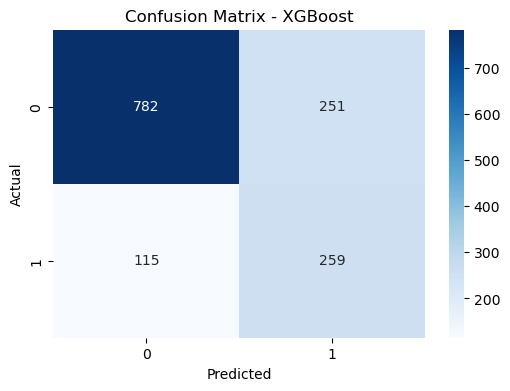

In [71]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize = (6,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

* __TP (True Positives)__: Churners correctly predicted as churn

* __TN (True Negatives)__: Non-churners correctly predicted as non-churn

* __FP (False Positives)__: Non-churners incorrectly predicted as churn

* __FN (False Negatives)__: Churners incorrectly predicted as non-churn

__Classification Report__

In [72]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1033
           1       0.51      0.69      0.59       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.78      0.74      0.75      1407



> __Accuracy__:
> 0.74
>
> __Precision & Recall__:
>
> * Churn (1):
>   - Precision  gives a moderate precision of 51% predicted as churns from the total actually churned.
>   - Recall model identifies 69% of actual churners.
>   - F1-score: 0.59 → moderate, reflects decent recall with lower precision.
>
> * Churn (0):
>   - Has better precision, recall, f1-score performance.

__Feature Importance__

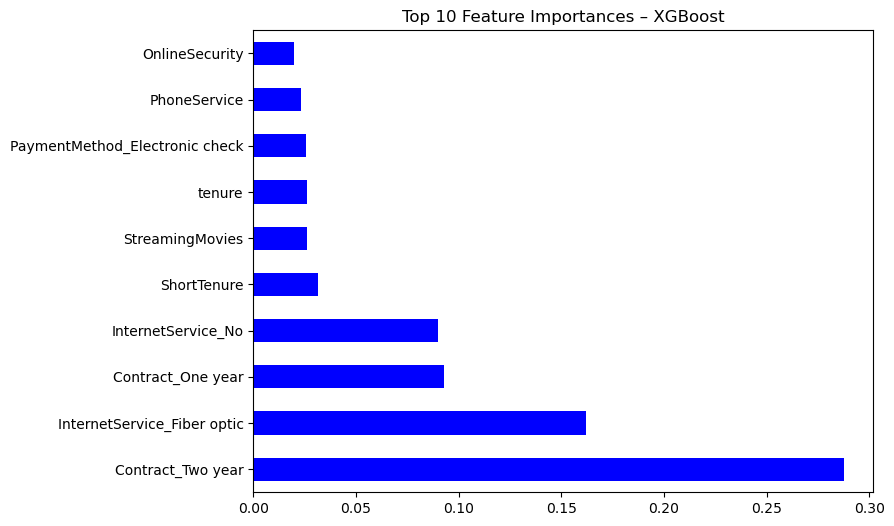

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
importance.sort_values(ascending=False).head(10).plot(kind='barh', figsize=(8,6), color='blue')
plt.title("Top 10 Feature Importances – XGBoost")
plt.show()

#### Summary

* Accuracy: Overall correctness (less important for imbalanced data).

* Precision (churn): How many predicted churners actually churn.

* Recall (churn): How many actual churners are caught — key metric for retention.

* F1-score: Balances precision and recall → single-number measure of churn detection effectiveness.

### Business Recommendations & Insights

After analyzing customer data and building predictive models for churn, several actionable insights have emerged to help reduce customer attrition and improve retention strategies.

__1. Identify High-Risk Customers__

Our models, particularly XGBoost, effectively predict customers with a high probability of churn. The primary drivers of churn are month-to-month contracts, shorter tenure, higher monthly charges, and lack of key services such as online security or tech support. By focusing retention efforts on these high-risk customers, the company can proactively prevent attrition and prioritize resources where they will have the greatest impact.

__2. Targeted Retention Campaigns__

For customers identified as high-risk, targeted campaigns should be implemented. Examples include offering discounts, loyalty rewards, or service bundles. Specifically, new customers (with tenure less than one year) and those on month-to-month plans are most vulnerable and should receive personalized retention offers. Bundling services like tech support or online security can also increase customer stickiness and reduce churn.

__3. Service and Pricing Improvements__

Churn analysis indicates that customers with fiber optic internet and higher monthly charges are more likely to leave. Investigating service quality issues and offering flexible pricing options may reduce dissatisfaction. Introducing tiered plans, promotions, or discounts for high-value customers can further mitigate churn risk.

__4. Monitoring and Continuous Improvement__

Retention efforts should be continuously monitored for effectiveness. Metrics such as campaign ROI, changes in churn rates, and customer feedback should inform adjustments to the strategy. Additionally, retraining predictive models periodically with fresh data ensures that the company remains responsive to evolving customer behavior.

__Conclusion__

By leveraging predictive analytics and focusing on the key drivers of churn, the company can implement data-driven strategies to retain customers more effectively. The combination of targeted retention campaigns, service improvements, and ongoing monitoring provides a structured approach to minimizing churn and maximizing long-term customer value.

### Key Metrics, Confusion Matrix, Top Features

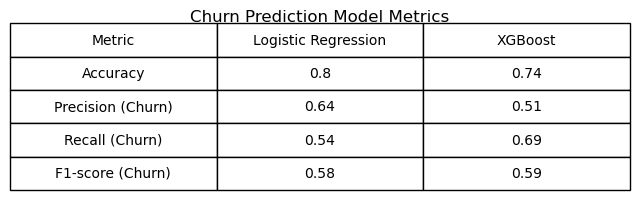

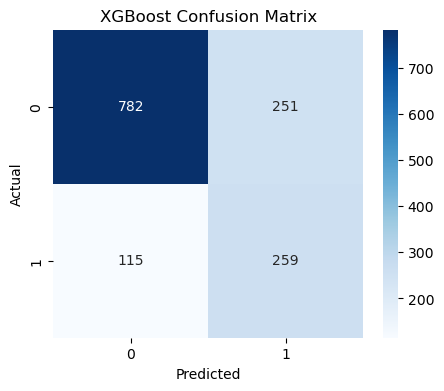

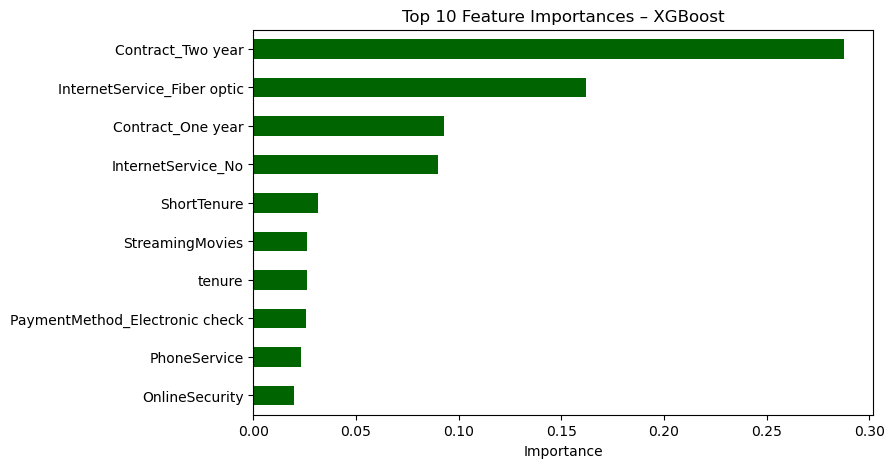

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Key Metrics Table
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Churn)', 'Recall (Churn)', 'F1-score (Churn)'],
    'Logistic Regression': [0.80, 0.64, 0.54, 0.58],
    'XGBoost': [0.74, 0.51, 0.69, 0.59]
})

# Plot key metrics table
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
tbl = ax.table(cellText=metrics.values, colLabels=metrics.columns, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 2)
plt.title("Churn Prediction Model Metrics", fontsize=12)
plt.show()

# Confusion Matrix for XGBoost
cm = [[782, 251],
      [115, 259]]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

# Top 10 Feature Importances from XGBoost
importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
importance.sort_values(ascending=False).head(10).plot(kind='barh', figsize=(8,5), color='darkgreen')
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances – XGBoost")
plt.gca().invert_yaxis()
plt.show()